## Problem 3: Clustering Problem 
The data in the file clustering_diabetesdata.csv is collected from 768 patients tested for
diabetes. The dataset consists of following features:
1. Number of times pregnant
2. Plasma glucose concentration)
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)

# Importing needed packages

In [64]:
import pandas as pd
import numpy as np
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.datasets import make_blobs 
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression


from sklearn.cluster import KMeans
%matplotlib inline

# 1) Import the data

In [65]:
df = pd.read_csv('clustering_diabetesdata.csv')
df.head()

Numb_of_Times_Preg  PlasmaglucoseConcentration  BloodPressure  \
0                   6                         148             72   
1                   1                          85             66   
2                   8                         183             64   
3                   1                          89             66   
4                   0                         137             40   

   SkinFoldThickness  SerumInsulin   BMI  DiabetesPedigreeFunction  Age  
0                 35             0  33.6                     0.627   50  
1                 29             0  26.6                     0.351   31  
2                  0             0  23.3                     0.672   32  
3                 23            94  28.1                     0.167   21  
4                 35           168  43.1                     2.288   33

In [66]:
print(f'Shape {df.shape}')

Shape (768, 8)


## 2) Preprocess the data

### Zeros values

In [67]:
zeros_count = (df == 0).sum()
print(zeros_count)

Numb_of_Times_Preg            111
PlasmaglucoseConcentration      5
BloodPressure                  35
SkinFoldThickness             227
SerumInsulin                  374
BMI                            11
DiabetesPedigreeFunction        0
Age                             0
dtype: int64


### Missing values

In [68]:
df.isna().sum()

Numb_of_Times_Preg            0
PlasmaglucoseConcentration    0
BloodPressure                 0
SkinFoldThickness             0
SerumInsulin                  0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

In [69]:
df.isnull().sum()

Numb_of_Times_Preg            0
PlasmaglucoseConcentration    0
BloodPressure                 0
SkinFoldThickness             0
SerumInsulin                  0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

#### It is clear that the data has zeros values

Data handling approach :

Column 1 : "Numb_of_Times_Preg" : It is common for a person to have been pregnant 0 times. 0 won't be repalce in this case.

Column 2 : "PlasmaglucoseConcentration" : It is implausible to have 0 plasma glucose, these value will be remove.

Column 3 : "BloodPressure" : This is also biologically implausible for living person to have 0 values.

Column 4 : "SkinFoldThickness" : This could be the case that the measurement wasn't taken or recorded, considering from the large missing of 0.

Column 5 : "SerumInsulin" : Serum insulin can't be 0 in living person.

Column 6 : "BMI" : BMI have 0 values in some people which is not plausible.

Column 7 : "DiabetesPedigreeFunction" :There are zeros in this column.

Column 8 : "Age": 0 zeros would represents new born.

Data cleaning strategy:

For "PlasmaglucoseConcentration", "BloodPressure", "BMI" : employ median imputation.

For "SkinFoldThickness" and "SerumInsulin" : given a large amount of zeros, median impuation mighr not be the most effective to handle zeros values. Instead, prediction imputation will be implemented to converted zeros values to more representative values.

For "Numb_of_Times_Preg" left as it is, since 0 is valid.

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Numb_of_Times_Preg          768 non-null    int64  
 1   PlasmaglucoseConcentration  768 non-null    int64  
 2   BloodPressure               768 non-null    int64  
 3   SkinFoldThickness           768 non-null    int64  
 4   SerumInsulin                768 non-null    int64  
 5   BMI                         768 non-null    float64
 6   DiabetesPedigreeFunction    768 non-null    float64
 7   Age                         768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB


Expore more on the describe function and it will give us more details about numeric columns.

In [71]:
df.describe()

Numb_of_Times_Preg  PlasmaglucoseConcentration  BloodPressure  \
count          768.000000                  768.000000     768.000000   
mean             3.845052                  120.894531      69.105469   
std              3.369578                   31.972618      19.355807   
min              0.000000                    0.000000       0.000000   
25%              1.000000                   99.000000      62.000000   
50%              3.000000                  117.000000      72.000000   
75%              6.000000                  140.250000      80.000000   
max             17.000000                  199.000000     122.000000   

       SkinFoldThickness  SerumInsulin         BMI  DiabetesPedigreeFunction  \
count         768.000000    768.000000  768.000000                768.000000   
mean           20.536458     79.799479   31.992578                  0.471876   
std            15.952218    115.244002    7.884160                  0.331329   
min             0.000000      0.000000    0.000000                  0.078000   
25%             0.000000      0.000000   27.300000                  0.243750   
50%            23.000000     30.500000   32.000000                  0.372500   
75%            32.000000    127.250000   36.600000                  0.626250   
max            99.000000    846.000000   67.100000                  2.420000   

              Age  
count  768.000000  
mean    33.240885  
std     11.760232  
min     21.000000  
25%     24.000000  
50%     29.000000  
75%     41.000000  
max     81.000000

### Pre processing data

Variables that we needs to look closely are Glucose, Blood Pressure, SkinThickness, Insulin and BMI, all of which contains 0 among the observations.These variables can not be zero. These near zeros variance predictors need to be identified and eliminated prior to modeling.

We have come to the conclusion that, this given dataset is incomplete. Since this is a demonstration fro machine learning so we will converted these "PlasmaglucoseConcentration", "BloodPressure", "BMI" : use median imputation and 'SkinFoldThickness', 'SerumInsulin' using predicted imputation.

### For "PlasmaglucoseConcentration", "BloodPressure", "BMI" : use median imputation.

We use Histogram to compare data distribution of features before and after median imputation. 

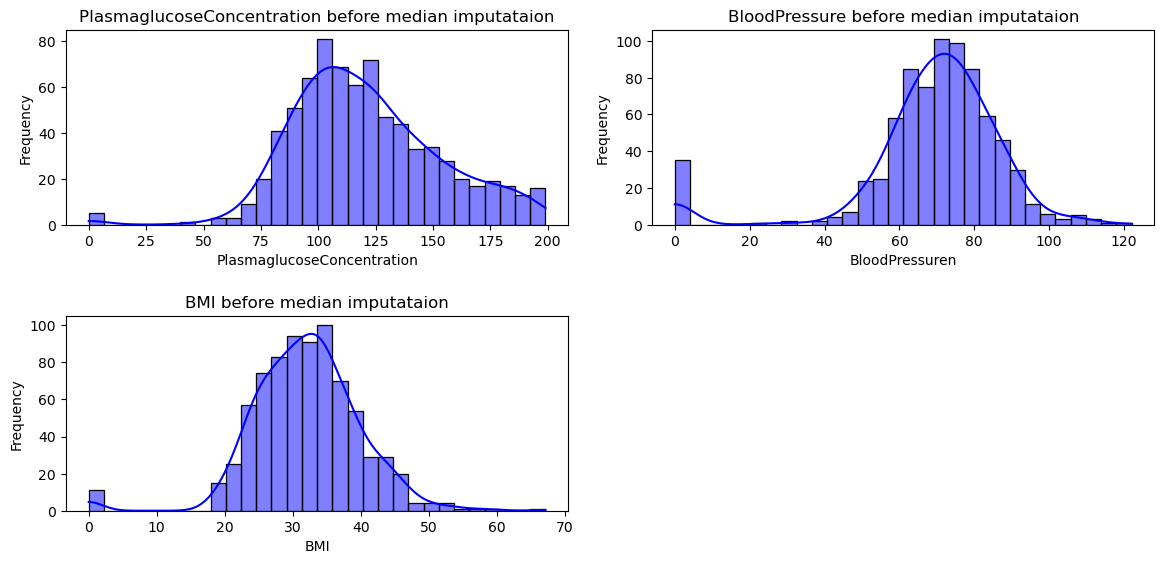

In [72]:
# Before Median Imputation

plt.figure(figsize=(12, 6))

# Plot for 'PlasmaglucoseConcentration' before imputation
plt.subplot(2, 2, 1)
sns.histplot(df['PlasmaglucoseConcentration'], kde=True, color='blue', bins=30)
plt.title('PlasmaglucoseConcentration before median imputataion')
plt.xlabel('PlasmaglucoseConcentration')
plt.ylabel('Frequency')

# Plot for 'BloodPressure' before imputation
plt.subplot(2, 2, 2)
sns.histplot(df['BloodPressure'], kde=True, color='blue', bins=30)
plt.title('BloodPressure before median imputataion')
plt.xlabel('BloodPressuren')
plt.ylabel('Frequency')


# Plot for 'BMI' before imputation
plt.subplot(2, 2, 3)
sns.histplot(df['BMI'], kde=True, color='blue', bins=30)
plt.title('BMI before median imputataion')
plt.xlabel('BMI')
plt.ylabel('Frequency')

plt.tight_layout(pad=2.0)
plt.show()


#### The following function cleans the data and replace the data with NaNs. 

In [73]:
def zeros_to_nans(df, columns_with_zeros=['PlasmaglucoseConcentration', 'BloodPressure','BMI']):

    df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)
    return df

df_clean_dataset = zeros_to_nans(df)
df_clean_dataset.head()

Numb_of_Times_Preg  PlasmaglucoseConcentration  BloodPressure  \
0                   6                       148.0           72.0   
1                   1                        85.0           66.0   
2                   8                       183.0           64.0   
3                   1                        89.0           66.0   
4                   0                       137.0           40.0   

   SkinFoldThickness  SerumInsulin   BMI  DiabetesPedigreeFunction  Age  
0                 35             0  33.6                     0.627   50  
1                 29             0  26.6                     0.351   31  
2                  0             0  23.3                     0.672   32  
3                 23            94  28.1                     0.167   21  
4                 35           168  43.1                     2.288   33

In [74]:
# NaN values after converted 0 to NaN.
df.isna().sum()

Numb_of_Times_Preg             0
PlasmaglucoseConcentration     5
BloodPressure                 35
SkinFoldThickness              0
SerumInsulin                   0
BMI                           11
DiabetesPedigreeFunction       0
Age                            0
dtype: int64

#### Change Nans to median, any missing values (NaNs) in the columns 'PlasmaglucoseConcentration', 'Blood pleasure' and 'BMI' will be replaced with respective number.


In [75]:
for i in df_clean_dataset:
    
    df_clean_dataset[i].fillna(df_clean_dataset[i].median(),inplace=True)

print('')
print(f'Shape: {df.shape}')

df.head(10)


Shape: (768, 8)


Numb_of_Times_Preg  PlasmaglucoseConcentration  BloodPressure  \
0                   6                       148.0           72.0   
1                   1                        85.0           66.0   
2                   8                       183.0           64.0   
3                   1                        89.0           66.0   
4                   0                       137.0           40.0   
5                   5                       116.0           74.0   
6                   3                        78.0           50.0   
7                  10                       115.0           72.0   
8                   2                       197.0           70.0   
9                   8                       125.0           96.0   

   SkinFoldThickness  SerumInsulin   BMI  DiabetesPedigreeFunction  Age  
0                 35             0  33.6                     0.627   50  
1                 29             0  26.6                     0.351   31  
2                  0             0  23.3                     0.672   32  
3                 23            94  28.1                     0.167   21  
4                 35           168  43.1                     2.288   33  
5                  0             0  25.6                     0.201   30  
6                 32            88  31.0                     0.248   26  
7                  0             0  35.3                     0.134   29  
8                 45           543  30.5                     0.158   53  
9                  0             0  32.3                     0.232   54

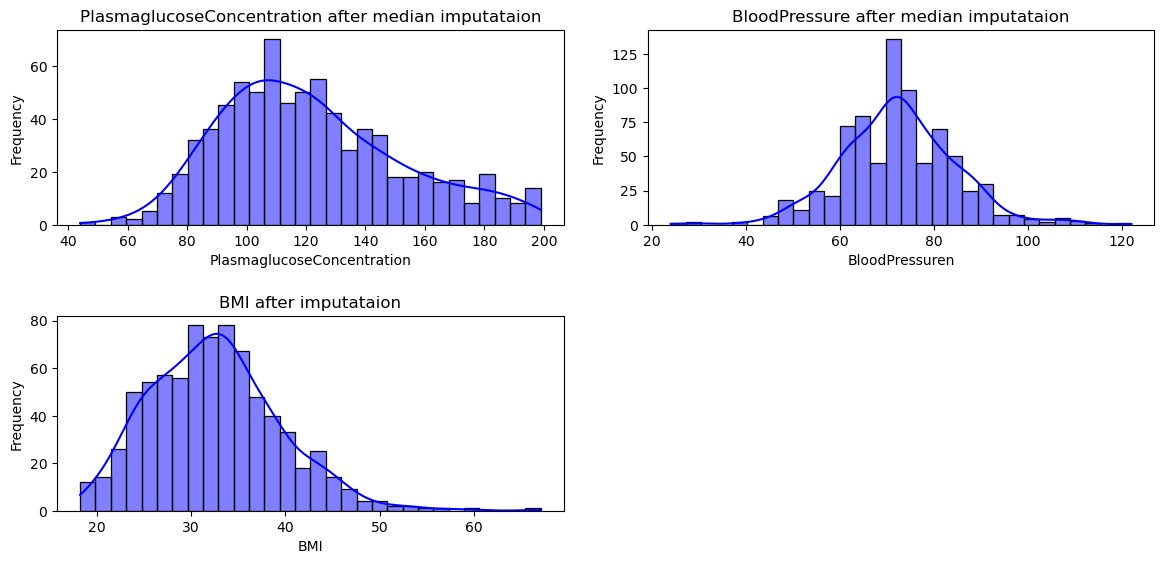

In [76]:
# After median Imputation
plt.figure(figsize=(12, 6))

# Plot for 'PlasmaglucoseConcentration' before imputation
plt.subplot(2, 2, 1)
sns.histplot(df['PlasmaglucoseConcentration'], kde=True, color='blue', bins=30)
plt.title('PlasmaglucoseConcentration after median imputataion')
plt.xlabel('PlasmaglucoseConcentration')
plt.ylabel('Frequency')

# Plot for 'BloodPressure' before imputation
plt.subplot(2, 2, 2)
sns.histplot(df['BloodPressure'], kde=True, color='blue', bins=30)
plt.title('BloodPressure after median imputataion')
plt.xlabel('BloodPressuren')
plt.ylabel('Frequency')

# Plot for 'BMI' before imputation
plt.subplot(2, 2, 3)
sns.histplot(df['BMI'], kde=True, color='blue', bins=30)
plt.title('BMI after imputataion')
plt.xlabel('BMI')
plt.ylabel('Frequency')

plt.tight_layout(pad=2.0)
plt.show()


Note : Right-skewed (positively skewed): Most of the data are on the left side of the distribution, but the tail (longer end) is to the right.

Note : Histogram graphs indicated the frequency distribution of certain medical measurement before and after median imputation.


### Given these observations: 

#### "PlasmaglucloseConcentration"
- Before median impution: There is noticable number of record near 0, represent the zero values. The distribution is right skewed.
- After median imputation: Zeros were replaced with median of distribution. The distribution remians right skewed but with fewer recods near 0. Median imputaion has increase the concentration of the data arounds the median, make the distribution more sysmmetric.


#### "BloodPressure"
- Before median impution: There is bar near 0, indicate the presence of zero values. The distribution has bell-shaped with a slight right skewed.
- After median imputation: Thee bar near 0 has decreased, implying that 0 were replaceed with median of distribution. The overall shape of distribution is quite similar, suggesting that median imputation has not drastically altered the inherit structure of the data. Howver, the central region's height has increased due to imputed values.


#### "BMI"
- Before median impution: The distribution is roughly bell-shaped. There a number of record near zeros value.
- After median imputation: It's noticable that zeros were replaced with median distribution. The distribution remains roughly bell-shaped.

Hence, the shown of outliers and skewness in some of variables before medain imputataion make median imputation suitable for this data. because it provides robuts measure of central tendency that isn't influence by extream values. We don't use mean in this case, because it is easily affected by outliers.

### For "SkinFoldThickness" and "SerumInsulin" : due to large amount of zeros use predictive impuation.

Text(0, 0.5, 'Frequency')

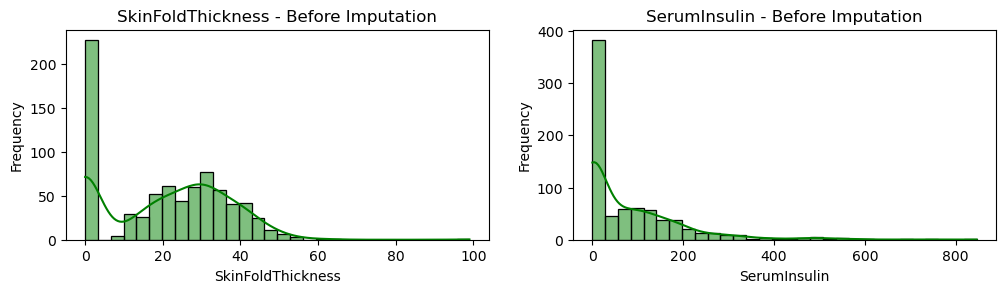

In [77]:
# Distribution before imputaion

# Before Imputation
plt.figure(figsize=(12, 6))

# Plot for 'SkinFoldThickness' before imputation
plt.subplot(2, 2, 1)
sns.histplot(df['SkinFoldThickness'], kde=True, color='green', bins=30)
plt.title('SkinFoldThickness - Before Imputation')
plt.xlabel('SkinFoldThickness')
plt.ylabel('Frequency')

# Plot for 'SerumInsulin' before imputation
plt.subplot(2, 2, 2)
sns.histplot(df['SerumInsulin'], kde=True, color='green', bins=30)
plt.title('SerumInsulin - Before Imputation')
plt.xlabel('SerumInsulin')
plt.ylabel('Frequency')

In [78]:

# Replace zeros with NaN for 'SkinFoldThickness' and 'SerumInsulin' columns
df['SkinFoldThickness'].replace(0, np.nan, inplace=True)
df['SerumInsulin'].replace(0, np.nan, inplace=True)


def predictive_imputation(df, col):
    
    # Split the data into rows with non-missing and missing target values
    train = df.dropna(subset=[col])
    test = df[df[col].isna()]

    # Define features (excluding the target column)
    features = df.columns.drop(col)

    # Check if there are rows with missing values
    if test.shape[0] == 0:
        return df

    # Handle missing values in the features using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    train[features] = imputer.fit_transform(train[features])
    test[features] = imputer.transform(test[features])

    # Train a regression model
    reg = LinearRegression()
    reg.fit(train[features], train[col])

    # Predict missing values
    test[col] = reg.predict(test[features])

    # Combine datasets back together
    df = pd.concat([train, test])

    return df

df = predictive_imputation(df, 'SkinFoldThickness')
df = predictive_imputation(df, 'SerumInsulin')

df.head()


C:\Users\bruker1\AppData\Local\Temp\ipykernel_31476\1498476955.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = imputer.fit_transform(train[features])
C:\Users\bruker1\AppData\Local\Temp\ipykernel_31476\1498476955.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = imputer.transform(test[features])
C:\Users\bruker1\AppData\Local\Temp\ipykernel_31476\1498476955.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

Numb_of_Times_Preg  PlasmaglucoseConcentration  BloodPressure  \
0                 6.0                       148.0           72.0   
1                 1.0                        85.0           66.0   
3                 1.0                        89.0           66.0   
4                 0.0                       137.0           40.0   
6                 3.0                        78.0           50.0   

   SkinFoldThickness  SerumInsulin   BMI  DiabetesPedigreeFunction   Age  
0               35.0    155.548223  33.6                     0.627  50.0  
1               29.0    155.548223  26.6                     0.351  31.0  
3               23.0     94.000000  28.1                     0.167  21.0  
4               35.0    168.000000  43.1                     2.288  33.0  
6               32.0     88.000000  31.0                     0.248  26.0

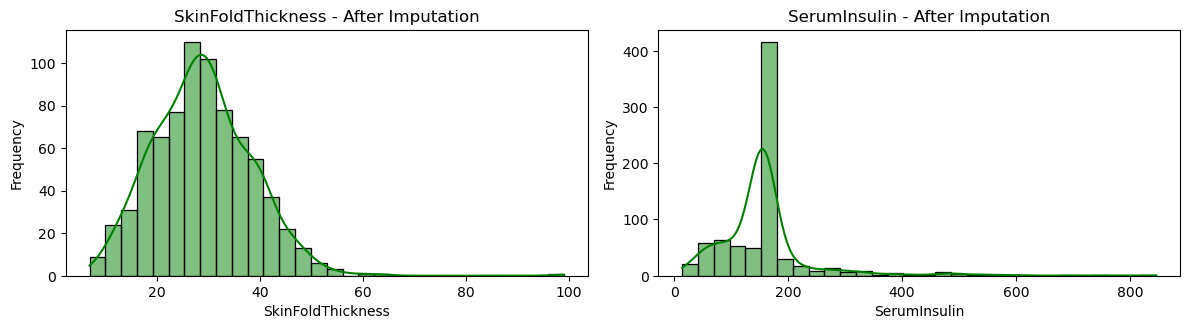

In [79]:
# Distribution of datapoint after imputation

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your original dataframe is called 'original_df' 
# and the imputed dataframe is 'df'.

# Before Imputation
plt.figure(figsize=(12, 6))



# After Imputation
# Plot for 'SkinFoldThickness' after imputation
plt.subplot(2, 2, 3)
sns.histplot(df['SkinFoldThickness'], kde=True, color='green', bins=30)
plt.title('SkinFoldThickness - After Imputation')
plt.xlabel('SkinFoldThickness')
plt.ylabel('Frequency')

# Plot for 'SerumInsulin' after imputation
plt.subplot(2, 2, 4)
sns.histplot(df['SerumInsulin'], kde=True, color='green', bins=30)
plt.title('SerumInsulin - After Imputation')
plt.xlabel('SerumInsulin')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Given these observations: 

#### "SkinFoldTickness" : 
- Brfore Imputation: A large number of datapoint have 0 value, which is an outlier and seems to be slight right skewed.
- After : The predictive computation has effectively remove 0 values, noticed from the large bar of 0 disappeared. The distruction of the data points remains on right skewed distribution. The histograms shows that this is look like a typical distribution without extream outlier.

#### "Seruminsulin" :
- Before : The histogram shows the significant amount of data point at 0 value again, the others distribution of datapoint maintains on right skewed. 
- After: The distribution of dataset remains on the right skewed  while the the large peak at 0 is gone. But the histogram shows a tall peak at a specific value.


From plotting histograms comparing data distributions of data point before and after impution, predictive impution has worked in sense that it filled zeros values, change in the shape of distribution and preserve the original skewness of distribution, in the way of predicting the overall structure of the original data. However, I remains hesitant about dropping rows with 0, as with this imputation method isn't truly original; It is educated guess base on other features. For furthur study, I would validate these results, perhaps comparing various imputation methods, to determine which features most influence the imputed values.

## Normalization

In [80]:
from sklearn.preprocessing import StandardScaler

# 2D Numpy array to beable to plot 
X = df.values[:,1:] # convert to an array because sklearn work with array.
# extracting the values from a pandas DataFrame and performing slicing on them to generate a new array.
# 

cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 0.86604475, -0.03198993,  0.63942155, ...,  0.16661938,
         0.46849198,  1.4259954 ],
       [-1.20506583, -0.5283186 ,  0.01057377, ..., -0.85219976,
        -0.36506078, -0.19067191],
       [-1.07356674, -0.5283186 , -0.61827401, ..., -0.63388137,
        -0.92076261, -1.04154944],
       ...,
       [ 2.24678514,  1.62243896,  0.71875276, ...,  0.443156  ,
        -0.58552944,  2.78739945],
       [-1.07356674, -0.85920438, -1.01563736, ..., -1.44893669,
        -0.99626558, -0.0204964 ],
       [ 0.14279979, -1.02464727, -0.11326835, ..., -0.34279019,
        -0.37110101,  1.17073215]])

In [81]:
X = df.values
X

array([[6.00e+00, 1.48e+02, 7.20e+01, ..., 3.36e+01, 6.27e-01, 5.00e+01],
       [1.00e+00, 8.50e+01, 6.60e+01, ..., 2.66e+01, 3.51e-01, 3.10e+01],
       [1.00e+00, 8.90e+01, 6.60e+01, ..., 2.81e+01, 1.67e-01, 2.10e+01],
       ...,
       [6.00e+00, 1.90e+02, 9.20e+01, ..., 3.55e+01, 2.78e-01, 6.60e+01],
       [9.00e+00, 8.90e+01, 6.20e+01, ..., 2.25e+01, 1.42e-01, 3.30e+01],
       [1.00e+00, 1.26e+02, 6.00e+01, ..., 3.01e+01, 3.49e-01, 4.70e+01]])

# 3) Implement algorithm models

## KMeans

In [82]:
from sklearn.cluster import KMeans

error = []
for i in range(1, 10):
    kmeans = KMeans(init = 'k-means++', n_clusters = i, n_init = 12)
    kmeans.fit(cluster_dataset)
    error.append(kmeans.inertia_)
    
#Note : A Scree plot compares the sum of Squared error (sse) for each variance of total cluster. SSE is measured as the sum of squared distance between the centroid and the others neighbors inside the cluster.In the nutshell, SSE drops as  ore clusters are produced.


C:\Users\bruker1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\bruker1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\bruker1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\bruker1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

The Elbow method will determind the number of cluster in dataset. The idea is to run the K-Means clustering on the range of value of k (k from 1 to 10 in this case), Then for each value of k compute the sum of squared distance from each point to it assigned center.

From the plot, the curve flatten out after 3 clusters, mean that the addition of more clusters does not explain much more of variance.The elbow in the plot whic the point after which the distortion/inertia start decreasing, the optimal number of clusters appears to be around 3, so k=3 might be a good choice for the number of clusters.


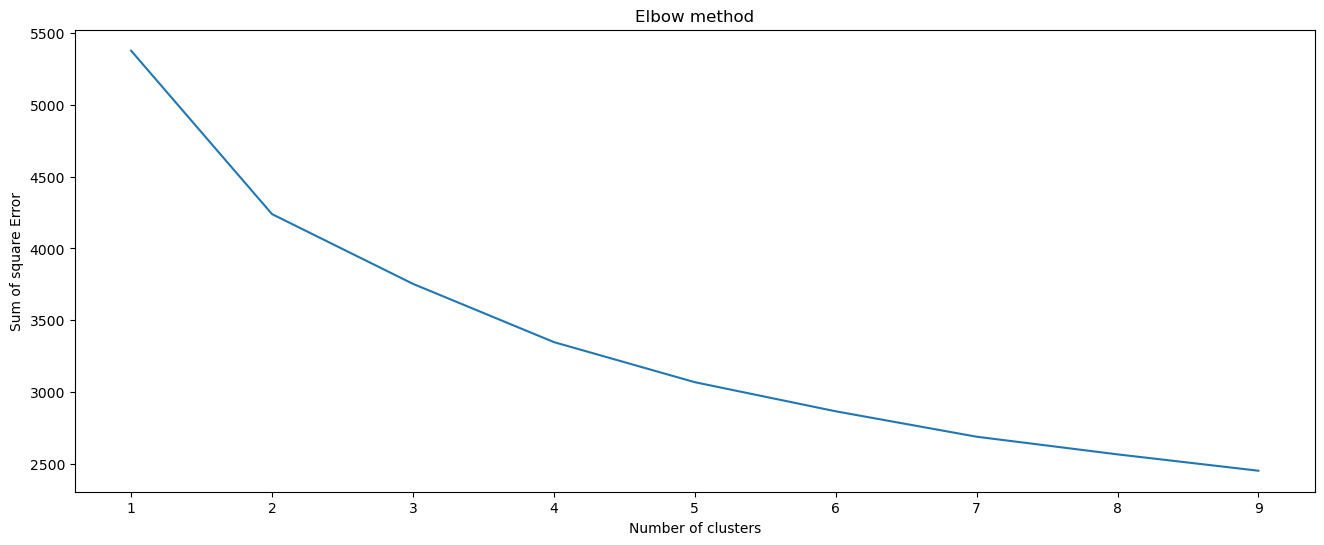

In [83]:
import matplotlib.pyplot as plt
plt.plot(range(1,10), error)
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of square Error')
plt.show()

## Choose an optimum value of K and use K-means.

In [84]:
clusterNum = 3
k_means = KMeans(init = 'k-means++', n_clusters = clusterNum, n_init = 12)

k_means.fit(cluster_dataset)
labels = k_means.labels_
print('Cluster memberships:\n\n{}'.format(labels))

kmeans.predict(cluster_dataset)

C:\Users\bruker1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Cluster memberships:

[0 2 2 1 2 0 0 0 1 2 2 1 2 0 0 2 0 0 1 2 0 2 0 1 1 2 0 0 1 2 1 2 2 2 0 1 2
 1 1 1 2 2 0 2 0 2 2 2 2 2 1 2 2 2 2 2 1 2 0 2 2 1 2 0 2 2 2 1 2 2 2 2 2 1
 0 2 0 2 2 1 1 2 1 1 2 0 0 1 1 2 2 2 2 1 1 2 1 2 2 2 2 1 0 1 1 2 2 2 1 0 1
 1 2 2 2 2 2 2 1 2 1 1 2 2 0 0 1 2 1 1 2 1 2 1 2 2 2 2 0 2 0 2 0 2 1 0 1 0
 1 1 2 2 1 0 2 2 1 1 1 1 2 2 0 1 0 2 2 2 1 0 1 1 2 2 2 2 2 2 2 2 0 0 2 0 2
 1 1 2 1 1 2 2 2 0 0 0 1 1 2 1 2 2 1 1 1 1 2 0 2 1 1 0 2 2 2 2 1 2 2 1 2 2
 1 2 2 2 0 2 2 1 1 2 0 2 2 1 1 2 2 2 0 2 2 1 0 2 1 1 0 1 1 0 1 2 2 2 0 1 2
 2 2 1 1 2 2 1 2 2 2 2 2 2 2 1 0 2 2 2 2 2 2 1 1 1 2 1 1 1 2 1 2 1 1 2 1 2
 1 2 1 2 1 1 0 1 0 2 2 2 0 2 0 2 2 2 1 2 1 2 2 2 1 2 0 2 1 0 0 2 2 2 2 2 1
 1 1 2 0 1 2 0 0 1 1 2 2 1 1 1 2 2 0 2 0 2 0 0 2 2 1 2 1 0 2 2 0 2 2 2 0 0
 2 1 2 2 2 2 2 1 2 1 1 1 2 0 2 2 0 0 2 0 0 2 2 2 2 0 1 1 1 2 2 2 2 2 0 2 2
 2 1 1 2 1 1 2 0 0 2 0 1 1 2 1 0 2 2 2 2 0 2 1 2 1 2 2 0 1 2 0 2 0 1 2 2 1
 2 1 2 2 1 2 2 2 1 0 1 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 0 2 2 0 0 2 0 1 2 2 1
 1 

array([4, 1, 1, 8, 6, 2, 2, 4, 3, 6, 6, 3, 5, 4, 5, 1, 4, 4, 0, 1, 4, 7,
       4, 6, 8, 0, 5, 4, 8, 1, 6, 1, 1, 1, 4, 2, 1, 0, 3, 6, 7, 5, 5, 1,
       5, 7, 0, 5, 5, 1, 6, 1, 1, 7, 1, 7, 3, 6, 0, 1, 5, 6, 7, 0, 1, 1,
       1, 3, 1, 7, 0, 6, 5, 0, 2, 6, 0, 1, 1, 3, 6, 6, 6, 6, 6, 5, 0, 0,
       6, 1, 1, 1, 1, 5, 5, 1, 0, 5, 5, 7, 1, 3, 8, 2, 3, 1, 7, 1, 8, 0,
       6, 3, 1, 7, 0, 5, 0, 7, 6, 1, 0, 3, 7, 1, 0, 2, 8, 6, 0, 6, 1, 3,
       1, 6, 0, 7, 7, 1, 4, 5, 4, 6, 0, 1, 3, 4, 6, 5, 3, 6, 5, 7, 2, 4,
       1, 5, 0, 2, 6, 2, 1, 1, 4, 3, 0, 1, 6, 7, 3, 8, 2, 2, 5, 1, 6, 7,
       6, 6, 1, 2, 8, 0, 6, 4, 7, 8, 8, 1, 6, 6, 1, 1, 7, 5, 5, 4, 2, 3,
       1, 6, 5, 6, 8, 6, 0, 2, 5, 5, 0, 6, 6, 0, 1, 7, 7, 5, 6, 0, 1, 8,
       1, 1, 6, 1, 5, 5, 4, 6, 0, 6, 3, 5, 7, 1, 1, 3, 8, 1, 7, 6, 4, 1,
       1, 3, 5, 1, 7, 6, 6, 8, 2, 4, 0, 6, 1, 5, 4, 8, 7, 1, 6, 6, 4, 1,
       6, 3, 7, 1, 7, 7, 1, 1, 5, 3, 4, 7, 5, 2, 1, 7, 7, 6, 0, 3, 5, 6,
       2, 3, 6, 8, 1, 6, 2, 7, 3, 1, 3, 1, 6, 1, 3,

In [85]:
# Using three cluster centers
kmeans_centers = k_means.cluster_centers_
kmeans_centers

array([[ 0.60252476,  0.54574714, -0.11579419,  0.13925144, -0.24652988,
        -0.1103641 ,  1.2495171 ],
       [ 0.39304746,  0.28807248,  1.08667803,  0.38540719,  1.11096543,
         0.3113329 , -0.14057351],
       [-0.54243654, -0.45148964, -0.57716164, -0.2980703 , -0.52370535,
        -0.12538747, -0.56459178]])

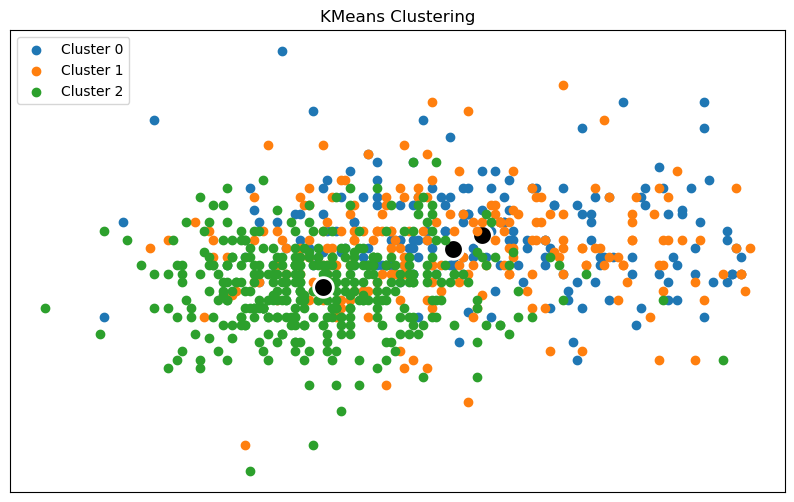

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels))))

for i in range(clusterNum):
    ax.scatter(cluster_dataset[labels == i, 0], cluster_dataset[labels == i, 1], label=f"Cluster {i}")
    ax.scatter(kmeans_centers[i, 0], kmeans_centers[i, 1], s=200, c='black', marker='o', edgecolor='white', linewidth=2)

ax.set_title("KMeans Clustering")

# Remove x-axis ticks
ax.set_xticks([])

# Remove y-axis ticks
ax.set_yticks([])

ax.legend()
plt.show()


## Insight

In [87]:
df['outcome'] = labels
df.head()

Numb_of_Times_Preg  PlasmaglucoseConcentration  BloodPressure  \
0                 6.0                       148.0           72.0   
1                 1.0                        85.0           66.0   
3                 1.0                        89.0           66.0   
4                 0.0                       137.0           40.0   
6                 3.0                        78.0           50.0   

   SkinFoldThickness  SerumInsulin   BMI  DiabetesPedigreeFunction   Age  \
0               35.0    155.548223  33.6                     0.627  50.0   
1               29.0    155.548223  26.6                     0.351  31.0   
3               23.0     94.000000  28.1                     0.167  21.0   
4               35.0    168.000000  43.1                     2.288  33.0   
6               32.0     88.000000  31.0                     0.248  26.0   

   outcome  
0        0  
1        2  
3        2  
4        1  
6        2

In [88]:
import plotly.express as px

# Assuming the clustering has been done and 'outcome' column has been added to the df
fig = px.scatter(df, x='Age', y='PlasmaglucoseConcentration', color='outcome',
                 size='BMI', hover_data=['BloodPressure', 'SerumInsulin', 'SkinFoldThickness', 'Numb_of_Times_Preg'])
fig.show()


### The goal of this is to understand :
1) How individual are grouped (clusterd) base on their age and plasma gluose concentration.
2) The distribution of BMI across these cluster (using the size og dots.)
3) How other matrix like blood pressure, serum insulin vary across and within these cluster.

### Check the centroid values by averageing the features in each cluster.
Gives the average values of each cloumn for each cluster.
Base on this aggregated data:

Visualization : 
- The scatter plot visualizes data points in term of "Age" (x-axis) and "PlasmaglucoseConcentration" (y_axis).
- The color represents what cluster its belongs to 'outcome (1,2,3)'.
- The size of each datapoint is determineded by the 'BMI' column.

Cluster insight :
- cluster 0 ('outcome = 0') reprensents younger individuals average age 26.59 with lower plasma glucose concentration(105.241758)
- cluster 1 ('outcome = 1') reprensents younger individuals average age  31.62 with lower plasma glucose concentration(133.334884)
- cluster 2 ('outcome = 2') reprensents younger individuals average age 47.952 with lower plasma glucose concentration(139.984127)


From observations:
These clusters suggest different health profiles or stages. Cluster 0 might represents healthy young adults, cluster 1 could represent adults who might be on the verge of or already have health complications, and Cluster 2 could represent order individuals with distinct health profiles.

In [89]:
df.groupby('outcome').mean()

Numb_of_Times_Preg  PlasmaglucoseConcentration  BloodPressure  \
outcome                                                                  
0                  6.126984                  139.984127      78.984127   
1                  3.570093                  133.612150      75.869159   
2                  2.824658                  105.156164      66.928767   

         SkinFoldThickness  SerumInsulin        BMI  DiabetesPedigreeFunction  \
outcome                                                                         
0                27.794290    167.379824  30.761376                  0.435333   
1                39.267390    188.294630  40.088318                  0.574963   
2                23.392264    130.222460  28.856986                  0.430359   

               Age  
outcome             
0        47.925926  
1        31.588785  
2        26.605479

### Is there any cluster in the dataset ?: 

Based on Elbow method of K-Means, there are three optimal cluster for this dataset  The location of the "elbow" where the reduction in SSD is slows down in the plot of SSD versus k, suggests that three clusters provide a good estimate for underlying structure of the data.

# Hierarchical clustering


## Use Hierarchical clustering to identify any clusters. Draw the dendogram.

Dendrogram (Hierarchical Clustering) : can be applied to visualize the arrangement of clusters in the form of a tree-like diagram called a dendogram. It can give a hint about the number od cluster.


## Clustering using scikit-learn


Making sure the accuracy of the distance matrix and that its values are symmetric, implement the euclidean_distances function. This matrix showcase the pairwise Euclidean between points in our datasets. The symmetry of the matrix value confrims its correctness.

In [90]:
from sklearn.metrics.pairwise import euclidean_distances
import pylab
dist_matrix = euclidean_distances(cluster_dataset,cluster_dataset) 
print(dist_matrix)

[[0.         3.04593278 3.8437715  ... 2.77321601 3.74612748 1.76197837]
 [3.04593278 0.         1.42054236 ... 5.25718676 1.40119979 2.04728511]
 [3.8437715  1.42054236 0.         ... 5.82203699 1.58262037 2.79046791]
 ...
 [2.77321601 5.25718676 5.82203699 ... 0.         5.64131167 3.9247144 ]
 [3.74612748 1.40119979 1.58262037 ... 5.64131167 0.         2.31400193]
 [1.76197837 2.04728511 2.79046791 ... 3.9247144  2.31400193 0.        ]]


Utilize the 'linkage' class from the hierachy model, save the results to variable 'Z' to captures the hierarchical clustering structure. 

In [91]:
Z = hierarchy.linkage(dist_matrix, 'complete')

C:\Users\bruker1\AppData\Local\Temp\ipykernel_31476\3518085107.py:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [92]:
Z

array([[5.75000000e+02, 7.06000000e+02, 1.35822558e+00, 2.00000000e+00],
       [5.64000000e+02, 5.88000000e+02, 2.26871581e+00, 2.00000000e+00],
       [2.24000000e+02, 6.91000000e+02, 2.49187788e+00, 2.00000000e+00],
       ...,
       [1.53000000e+03, 1.53100000e+03, 9.55460937e+01, 7.52000000e+02],
       [1.52000000e+03, 1.52900000e+03, 1.17422648e+02, 1.60000000e+01],
       [1.53200000e+03, 1.53300000e+03, 2.04727071e+02, 7.68000000e+02]])

### Use Linkage method
Plot the dendrogram. Then save the dendogram to a variable called 'dendro' In this code, dendrogrm will displayed using dendrogram class from hierachy.

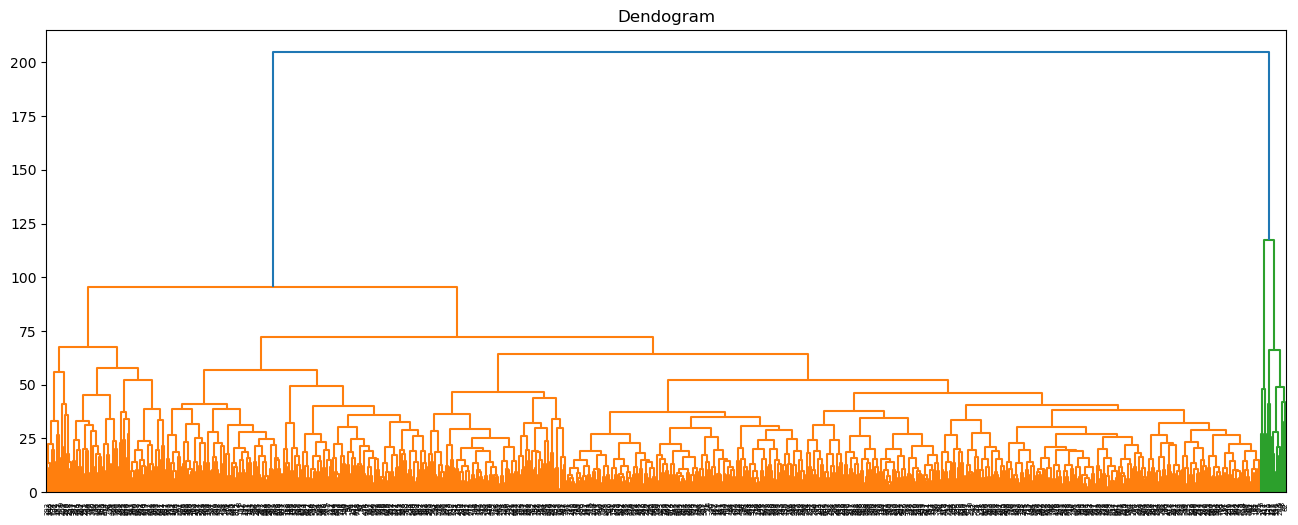

In [93]:
plt.rc("figure", figsize = (16,6))
dendro = hierarchy.dendrogram(Z)
plt.title('Dendogram')
plt.show()


Note : The biger the distance between two links, the bigger the different in terms of the chosen features, indicating a more significant difference between combined clusters. 

### Conclusion: 
As shown from dendrogram, the most substantial vertical line without any cuts appears to be the blue line at the top. Cutting the dendrogram at the height of this line would result in "two primary cluster".

Utilize 'AgglomerativeClustering' function from scikit-learn libary to provide cluster lables after clustering is done. It's seems that the majority of data points are labeled as 0 and fewer in 1, 2.

In [94]:
model =  AgglomerativeClustering(n_clusters = 6, linkage = 'complete')

model.fit(dist_matrix)

predicted_labels  = model.labels_
predicted_labels

C:\Users\bruker1\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:566: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



array([1, 1, 1, 0, 1, 0, 5, 4, 4, 2, 1, 4, 1, 4, 1, 1, 4, 1, 4, 1, 1, 1,
       1, 1, 3, 4, 4, 3, 0, 1, 1, 1, 1, 1, 3, 4, 1, 4, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1,
       1, 4, 1, 1, 1, 1, 1, 4, 2, 1, 4, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 4,
       1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 4, 4, 2, 4, 1, 1, 1, 4, 4,
       1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 4, 0, 1, 1, 4, 0, 4, 1, 1, 1, 1, 4,
       1, 4, 4, 1, 1, 1, 1, 1, 3, 1, 4, 1, 4, 3, 1, 1, 4, 1, 1, 1, 2, 4,
       1, 1, 4, 5, 1, 3, 1, 1, 4, 4, 4, 1, 1, 1, 1, 3, 0, 4, 1, 1, 1, 1,
       1, 1, 1, 2, 4, 1, 1, 3, 1, 4, 4, 1, 4, 4, 1, 1, 1, 1, 1, 1, 0, 4,
       1, 1, 1, 1, 4, 4, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4,
       1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 3, 1, 1, 4, 4, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 4, 1, 1, 4, 4, 3, 4, 1, 1, 1, 4, 0, 2, 1, 1, 4, 3, 1,
       1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 2, 1, 1, 4, 1, 1, 4,
       0, 1, 1, 4, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1,

In [95]:
df['cluster_'] = predicted_labels
df.head(10)

Numb_of_Times_Preg  PlasmaglucoseConcentration  BloodPressure  \
0                  6.0                       148.0           72.0   
1                  1.0                        85.0           66.0   
3                  1.0                        89.0           66.0   
4                  0.0                       137.0           40.0   
6                  3.0                        78.0           50.0   
8                  2.0                       197.0           70.0   
13                 1.0                       189.0           60.0   
14                 5.0                       166.0           72.0   
16                 0.0                       118.0           84.0   
18                 1.0                       103.0           30.0   

    SkinFoldThickness  SerumInsulin   BMI  DiabetesPedigreeFunction   Age  \
0                35.0    155.548223  33.6                     0.627  50.0   
1                29.0    155.548223  26.6                     0.351  31.0   
3                23.0     94.000000  28.1                     0.167  21.0   
4                35.0    168.000000  43.1                     2.288  33.0   
6                32.0     88.000000  31.0                     0.248  26.0   
8                45.0    543.000000  30.5                     0.158  53.0   
13               23.0    846.000000  30.1                     0.398  59.0   
14               19.0    175.000000  25.8                     0.587  51.0   
16               47.0    230.000000  45.8                     0.551  31.0   
18               38.0     83.000000  43.3                     0.183  33.0   

    outcome  cluster_  
0         0         1  
1         2         1  
3         2         1  
4         1         0  
6         2         1  
8         0         0  
13        0         5  
14        0         4  
16        1         4  
18        2         2

This is to explore how well the clustering algorithm has grouped the data point base on the to selected features,  'Age' and 'PlasmaglucoseConcentration'. 

C:\Users\bruker1\AppData\Local\Temp\ipykernel_31476\3836695265.py:15: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



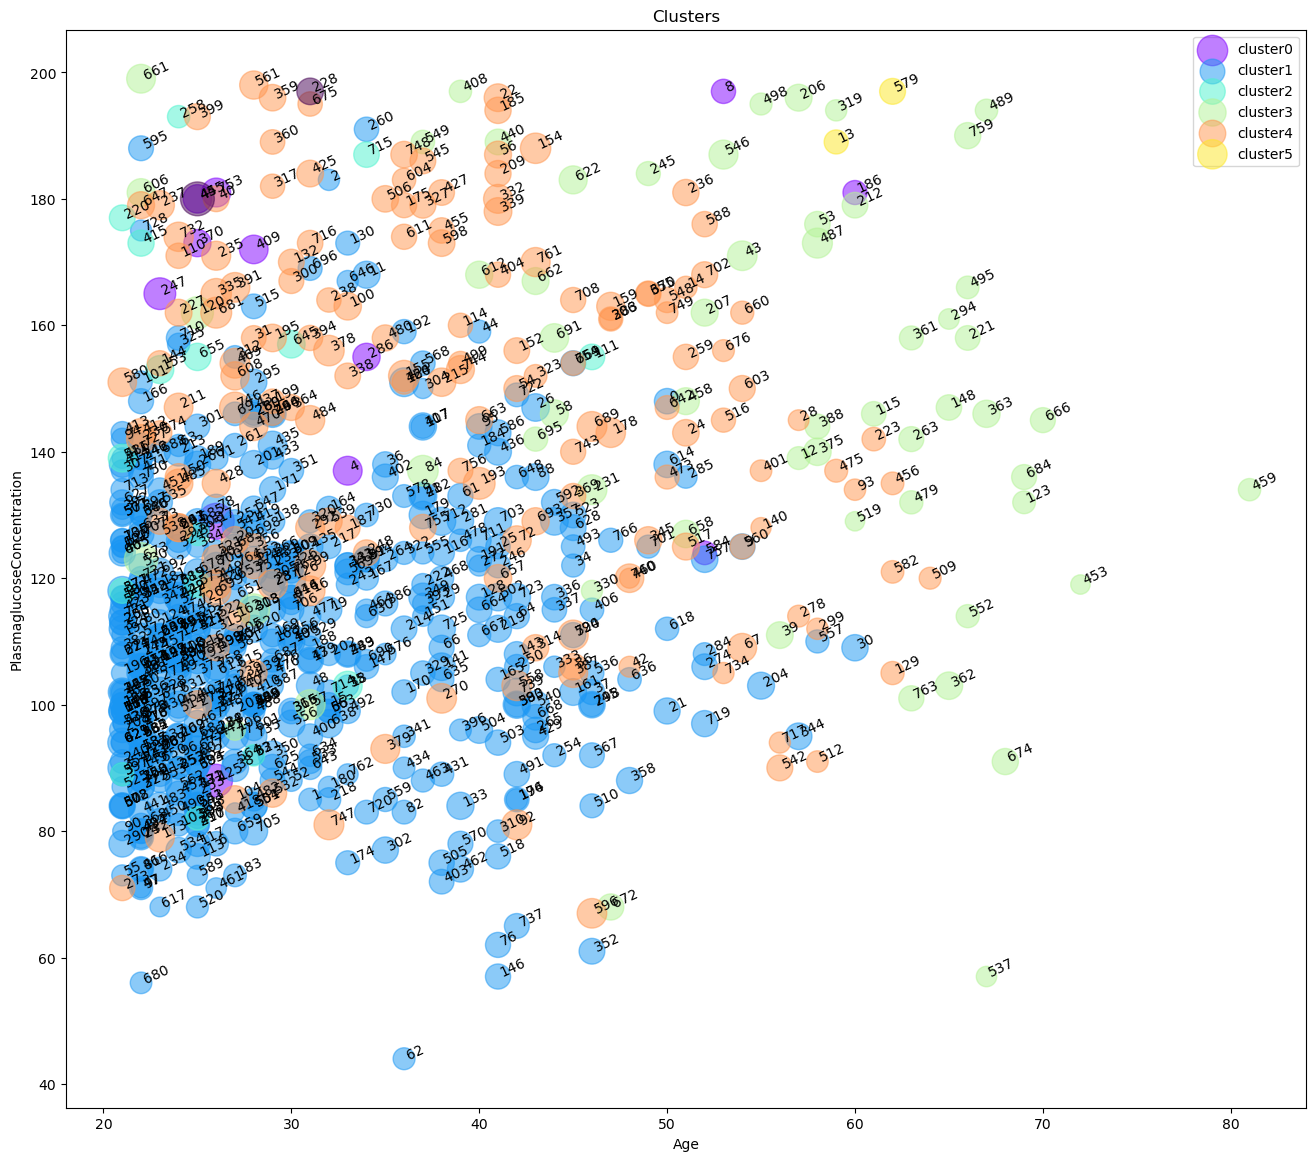

In [96]:

import matplotlib.cm as cm


n_clusters = max(predicted_labels)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Create a figure of size 16 inches by 14 inches.
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = df[df.cluster_ == label]
    for i in subset.index:
            plt.text(subset.Age[i], subset.PlasmaglucoseConcentration[i], str(i), rotation=25)  # annotate point with index
    plt.scatter(subset.Age, subset.PlasmaglucoseConcentration, s=subset.BMI*10, c=color, label='cluster'+str(label), alpha=0.5)

plt.legend()
plt.title('Clusters')
plt.xlabel('Age')
plt.ylabel('PlasmaglucoseConcentration')
plt.show()


The scatter plot above showcases the visualization provides a clear representation of how the data is grouped based on age and plasma glucose concentration, with the size of each data point providing additional information about the BMI. The clustering suggests potential relationships between age, glucose concentration, and BMI.The scatter plot visualizes clusters based on two features: Age on the x-axis and PlasmaglucoseConcentration on the y-axis. There are six distinct clusters (ranging from cluster0 to cluster5) as shown in the legend.

Observation: There doesn't seem to be a strong linear correlation between 'Age' and 'PlasmaglucoseConcentration' since the data points are distributed in a fairly broad manner. However, it can be observed that the highest concentrations of 'Plasmaglucose' tend to appear in the upper age range.